In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)
def missing_ratio(s):
    return s.isna().mean() * 100

In [3]:
pd.options.mode.chained_assignment = None

df = pd.read_csv("rawdata.csv", skipinitialspace=True)
df.head(2)

,DiaChi,TinhTrangBDS,DienTich,Gia/m2,Phongngu,TenPhanKhu,SoTang,PhongTam,Loai,GiayTo,MaCanHo,TinhTrangNoiThat,HuongCuaChinh,HuongBanCong,DacDiem,Gia
0,"Đường Nguyễn Văn Quỳ, Phường Phú Thuận, Quận 7...",Đã bàn giao,62 m²,"32,26 triệu/m²",2 phòng,NaN,nan,2 phòng,Chung cư,Đã có sổ,NaN,NaN,NaN,NaN,NaN,2 tỷ- 62 m2đ
1,"Đường Nguyễn Văn Linh, Phường Tân Thuận Tây, Q...",Đã bàn giao,95 m²,"55,79 triệu/m²",3 phòng,NaN,nan,2 phòng,Chung cư,Đang chờ sổ,NaN,Nội thất cao cấp,NaN,NaN,Căn góc,"5,3 tỷ- 95 m2đ"


In [4]:
#Chỉ lấy diện tích not null và có diện tích trong khoảng 20m2 đến 100m2
df = df[df.DienTich.notnull()]
df = df.reset_index()
for i in range(len(df.DienTich)):
    df.DienTich[i] = float(df.DienTich[i].split(' ')[0])
df = df[(df.DienTich >= 20) & (df.DienTich <= 100)]
df = df.reset_index()

In [5]:
#Chỉ lấy các căn hộ có dữ liệu về phòng ngủ và phòng tắm
df = df[df.SoTang.notnull()]
df = df[df.Phongngu.notnull()]
df = df[df.PhongTam.notnull()]
df = df.reset_index(drop=True)

#Xóa các chữ dư thừa (phòng, nhiều hơn, ...) trong dữ liệu
for i in range(len(df.Phongngu)):
    if "nhiều hơn" in df.Phongngu[i]:
        df.Phongngu[i]= int(df.Phongngu[i].split(' ')[2])+1
    else:
        df.Phongngu[i]= df.Phongngu[i].split(' ')[0]
for i in range(len(df.PhongTam)):
    if "Nhiều hơn" in df.PhongTam[i]:
        df.PhongTam[i]= int(df.PhongTam[i].split(' ')[2])+1
    else:
        df.PhongTam[i]= df.PhongTam[i].split(' ')[0]

In [6]:
#df = df[df.GiayTo == 'Đã có sổ']
df = df[df.TinhTrangNoiThat.isin(['Bàn giao thô', 'Hoàn thiện cơ bản', 'Nội thất đầy đủ', 'Nội thất cao cấp'])]
df = df.reset_index(drop=True)

In [7]:
#Loại bỏ những dòng dữ liệu có chứa từ khóa 'GIÁ TỐT' ở cột giá
df = df[~df.Gia.str.contains('GIÁ TỐT')]
df = df[df.Gia.str.contains('tỷ|triệu')]
df = df.reset_index(drop=True)
for i in range(len(df.Gia)):
    if 'tỷ' in df.Gia[i]:
        price = df.Gia[i].split(' ')[0]
        price = price.replace(',','.')
        df.Gia[i] = round(float(price)*1000000000,1)
    elif 'triệu' in df.Gia[i] :
        price = df.Gia[i].split(' ')[0]
        price = price.replace(',','.')
        df.Gia[i] = round(float(price)*1000000,1)

#Chỉ lấy các căn hộ có giá từ 50 triệu đến 10 tỷ
df = df[(df.Gia >= 50000000) & (df.Gia <= 10000000000)]
df = df.reset_index(drop=True)

In [8]:
#Tạo thêm cột 'Quận' để dễ dàng trong việc phân tích dữ liệu
df["Quan"] = df.DiaChi.copy()
for i in range(len(df.DiaChi)):
    address = df.DiaChi[i].split(',')
    df.Quan[i] = address[len(address)-2]
    
#Xóa các dòng dữ liệu không có 'Quận'
for i in df.Quan:
    if 'Quận' not in i and 'Huyện' not in i:
        df = df.drop(df[df.Quan == i].index)   

In [9]:
#Xóa các cột dữ liệu không sử dụng
del df["Gia/m2"]
del df["TenPhanKhu"]
del df["MaCanHo"]
del df["DiaChi"]
del df["level_0"]
del df["index"]
del df['DacDiem']

In [10]:
df.head(2)

,TinhTrangBDS,DienTich,Phongngu,SoTang,PhongTam,Loai,GiayTo,TinhTrangNoiThat,HuongCuaChinh,HuongBanCong,Gia,Quan
0,Đã bàn giao,70.0,1,7.0,1,Chung cư,Đang chờ sổ,Nội thất cao cấp,Đông Nam,Tây Bắc,4000000000.0,Quận Tân Bình
1,Đã bàn giao,50.0,1,3.0,1,Chung cư,Đã có sổ,Hoàn thiện cơ bản,Nam,Bắc,1390000000.0,Quận Bình Tân


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4681 entries, 0 to 4776
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TinhTrangBDS      4681 non-null   object 
 1   DienTich          4681 non-null   object 
 2   Phongngu          4681 non-null   object 
 3   SoTang            4681 non-null   float64
 4   PhongTam          4681 non-null   object 
 5   Loai              4681 non-null   object 
 6   GiayTo            4600 non-null   object 
 7   TinhTrangNoiThat  4681 non-null   object 
 8   HuongCuaChinh     3373 non-null   object 
 9   HuongBanCong      3268 non-null   object 
 10  Gia               4681 non-null   object 
 11  Quan              4681 non-null   object 
dtypes: float64(1), object(11)
memory usage: 475.4+ KB


In [12]:
df.duplicated().sum()

1285

In [13]:
df = df.drop_duplicates()

In [14]:
df.loc[:,:].agg([missing_ratio,pd.Series.min,pd.Series.max,pd.Series.nunique,pd.Series.unique])

,TinhTrangBDS,DienTich,Phongngu,SoTang,PhongTam,Loai,GiayTo,TinhTrangNoiThat,HuongCuaChinh,HuongBanCong,Gia,Quan
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,2.4,0.0,33.5,36.6,0.0,0.0
min,Chưa bàn giao,21.0,NaN,1.0,NaN,"Căn hộ dịch vụ, mini",NaN,Bàn giao thô,NaN,NaN,50000000.0,Huyện Bình Chánh
max,Đã bàn giao,100.0,NaN,720.0,NaN,Penthouse,NaN,Nội thất đầy đủ,NaN,NaN,10000000000.0,Quận Tân Phú
nunique,2,287,7,46,6,6,3,4,8,8,641,23
unique,"[Đã bàn giao, Chưa bàn giao]","[70.0, 50.0, 83.0, 51.0, 67.62, 68.0, 40.0, 85...","[1, 2, 3, 11, 6, 4, 5]","[7.0, 3.0, 5.0, 6.0, 14.0, 4.0, 15.0, 20.0, 28...","[1, 2, 3, 7, 5, 4]","[Chung cư, Duplex, Căn hộ dịch vụ, mini, Offi...","[Đang chờ sổ, Đã có sổ, Giấy tờ khác, nan]","[Nội thất cao cấp, Hoàn thiện cơ bản, Nội thất...","[Đông Nam, Nam, Tây Nam, Tây, Đông Bắc, nan, T...","[Tây Bắc, Bắc, Đông Bắc, nan, Tây Nam, Đông Na...","[4000000000.0, 1390000000.0, 4500000000.0, 170...","[ Quận Tân Bình, Quận Bình Tân, Quận Bình Th..."


In [15]:
for col in ['GiayTo', 'HuongCuaChinh', 'HuongBanCong']:
    df[col] = df[col].fillna(df[col].mode()[0])

In [16]:
df.DienTich = pd.to_numeric(df.DienTich)
df.Phongngu = pd.to_numeric(df.Phongngu)
df.PhongTam = pd.to_numeric(df.PhongTam)
df.Gia = pd.to_numeric(df.Gia)
df['GiayTo']=df['GiayTo'].astype('str')
df['HuongCuaChinh']=df['HuongCuaChinh'].astype('str')
df['HuongBanCong']=df['HuongBanCong'].astype('str')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3396 entries, 0 to 4776
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TinhTrangBDS      3396 non-null   object 
 1   DienTich          3396 non-null   float64
 2   Phongngu          3396 non-null   int64  
 3   SoTang            3396 non-null   float64
 4   PhongTam          3396 non-null   int64  
 5   Loai              3396 non-null   object 
 6   GiayTo            3396 non-null   object 
 7   TinhTrangNoiThat  3396 non-null   object 
 8   HuongCuaChinh     3396 non-null   object 
 9   HuongBanCong      3396 non-null   object 
 10  Gia               3396 non-null   float64
 11  Quan              3396 non-null   object 
dtypes: float64(3), int64(2), object(7)
memory usage: 344.9+ KB


In [18]:
df.loc[:,:].agg([missing_ratio,pd.Series.min,pd.Series.max,pd.Series.nunique,pd.Series.unique])

,TinhTrangBDS,DienTich,Phongngu,SoTang,PhongTam,Loai,GiayTo,TinhTrangNoiThat,HuongCuaChinh,HuongBanCong,Gia,Quan
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,Chưa bàn giao,21.0,1,1.0,1,"Căn hộ dịch vụ, mini",Giấy tờ khác,Bàn giao thô,Bắc,Bắc,50000000.0,Huyện Bình Chánh
max,Đã bàn giao,100.0,11,720.0,7,Penthouse,Đã có sổ,Nội thất đầy đủ,Đông Nam,Đông Nam,10000000000.0,Quận Tân Phú
nunique,2,287,7,46,6,6,3,4,8,8,641,23
unique,"[Đã bàn giao, Chưa bàn giao]","[70.0, 50.0, 83.0, 51.0, 67.62, 68.0, 40.0, 85...","[1, 2, 3, 11, 6, 4, 5]","[7.0, 3.0, 5.0, 6.0, 14.0, 4.0, 15.0, 20.0, 28...","[1, 2, 3, 7, 5, 4]","[Chung cư, Duplex, Căn hộ dịch vụ, mini, Offi...","[Đang chờ sổ, Đã có sổ, Giấy tờ khác]","[Nội thất cao cấp, Hoàn thiện cơ bản, Nội thất...","[Đông Nam, Nam, Tây Nam, Tây, Đông Bắc, Tây Bắ...","[Tây Bắc, Bắc, Đông Bắc, Đông Nam, Tây Nam, Na...","[4000000000.0, 1390000000.0, 4500000000.0, 170...","[ Quận Tân Bình, Quận Bình Tân, Quận Bình Th..."


In [19]:
obj_col = df.dtypes[df.dtypes == 'object'].index
obj_col

Index(['TinhTrangBDS', 'Loai', 'GiayTo', 'TinhTrangNoiThat', 'HuongCuaChinh',
       'HuongBanCong', 'Quan'],
      dtype='object')

In [20]:
num_col = df.dtypes[(df.dtypes == 'int') | (df.dtypes == 'float')  ].index
num_col

Index(['DienTich', 'Phongngu', 'SoTang', 'PhongTam', 'Gia'], dtype='object')

In [21]:
df.isna().sum()

TinhTrangBDS        0
DienTich            0
Phongngu            0
SoTang              0
PhongTam            0
Loai                0
GiayTo              0
TinhTrangNoiThat    0
HuongCuaChinh       0
HuongBanCong        0
Gia                 0
Quan                0
dtype: int64

In [22]:
df.corr()['Gia'].sort_values(ascending=False)[1:].head(20)

DienTich   0.6
PhongTam   0.4
Phongngu   0.4
SoTang     0.1
Name: Gia, dtype: float64

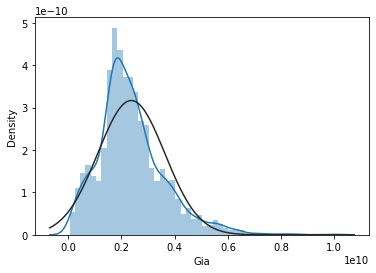

In [23]:
sns.distplot(df['Gia'], fit=norm);

In [24]:
outlier_index = df[df['Gia']>0.8e10].index
outlier_arr = list(outlier_index)

<AxesSubplot:xlabel='DienTich', ylabel='Gia'>

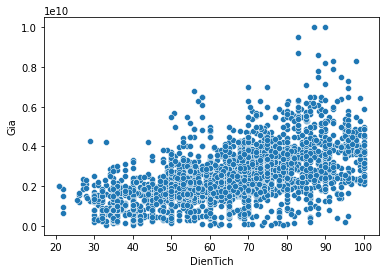

In [25]:
sns.scatterplot(data=df, x='DienTich', y='Gia')

In [26]:
outlier= df[(df['DienTich']<25)].index
outlier_arr = outlier_arr + list(outlier_index)

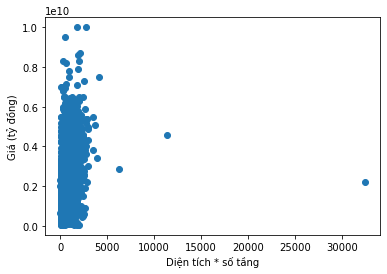

In [27]:
df_temp = df.copy()
plt.scatter(df_temp.SoTang*df_temp.DienTich, df_temp.Gia)
plt.xlabel('Diện tích * số tầng')
plt.ylabel('Giá (tỷ đồng)')
plt.show()

In [28]:
outlier= df[(df['DienTich']*df['SoTang']<5000)].index
outlier_arr = outlier_arr + list(outlier_index)

<AxesSubplot:xlabel='PhongTam', ylabel='Gia'>

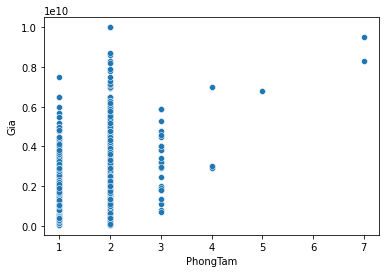

In [29]:
sns.scatterplot(data=df, x='PhongTam', y='Gia')

In [30]:
outlier_index = df[df['PhongTam']>4].index
outlier_arr = outlier_arr + list(outlier_index)

<AxesSubplot:xlabel='Phongngu', ylabel='Gia'>

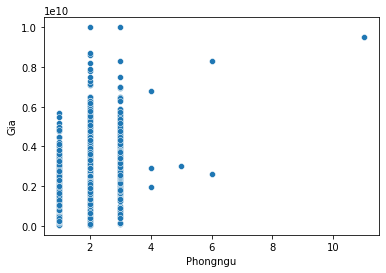

In [31]:
sns.scatterplot(data=df, x='Phongngu', y='Gia')

In [32]:
outlier_index = df[df['Phongngu']>4].index
outlier_arr = outlier_arr + list(outlier_index)

<AxesSubplot:>

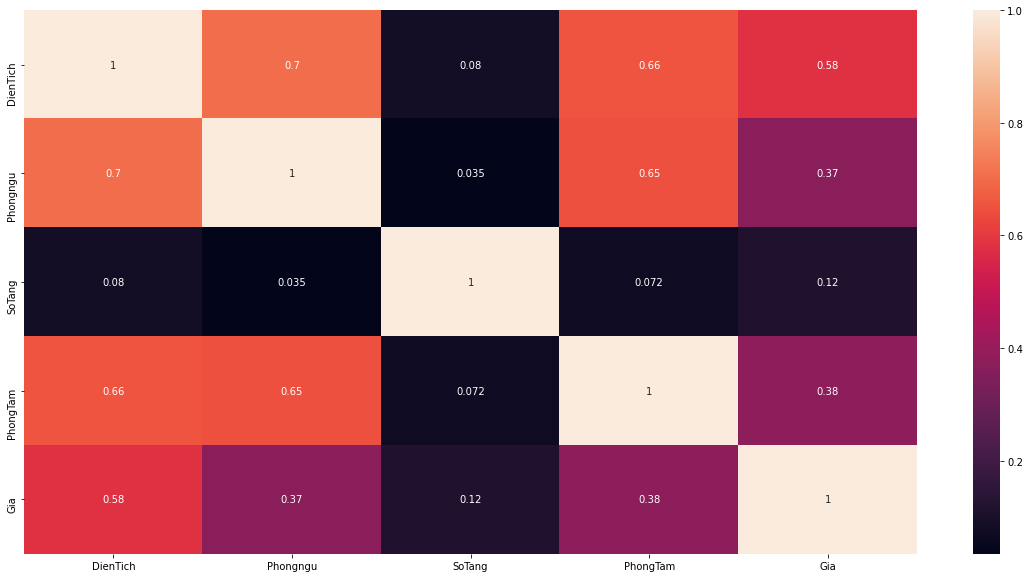

In [33]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True)

In [34]:
outlier_arr = list(dict.fromkeys(outlier_arr))

In [35]:
df.drop(outlier_arr, inplace=True)

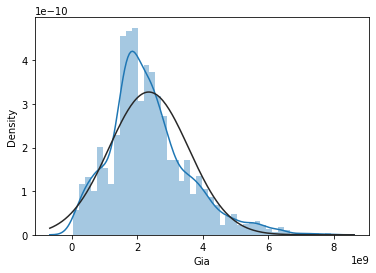

In [36]:
sns.distplot(df['Gia'], fit=norm);

In [37]:
missing_ratio = df.isna().sum()/len(df)
missing_ratio = missing_ratio.drop(missing_ratio[missing_ratio == 0].index).sort_values(ascending=False)
missing_df =  pd.DataFrame({'Missing ratio': missing_ratio})
missing_df

,Missing ratio


In [38]:
# Tiến hành label encode cho các cột catogorical không ở dạng số thành số để có thể tính được corr nhằm ko bỏ sót đặc trưng nào quan trọng

label = LabelEncoder()
for col in obj_col:
    df[col] = label.fit_transform(df[col])
# Kiểm tra lại
#df.info()

In [39]:
X= df[['TinhTrangBDS','DienTich','Phongngu','SoTang','PhongTam','Loai','GiayTo','TinhTrangNoiThat','HuongCuaChinh','HuongBanCong','Quan']]
X

,TinhTrangBDS,DienTich,Phongngu,SoTang,PhongTam,Loai,GiayTo,TinhTrangNoiThat,HuongCuaChinh,HuongBanCong,Quan
0,1,70.0,1,7.0,1,2,1,2,7,3,21
1,1,50.0,1,3.0,1,2,2,1,1,0,17
2,1,83.0,2,5.0,2,2,1,2,4,6,16
3,1,51.0,2,6.0,1,2,2,1,2,7,7
4,0,67.6,2,14.0,2,2,1,2,6,4,14
...,...,...,...,...,...,...,...,...,...,...,...
4771,0,40.0,1,5.0,1,0,1,3,7,7,17
4773,0,66.7,2,20.0,2,2,0,2,1,0,13
4774,1,48.0,1,19.0,1,2,1,2,4,3,5
4775,1,53.0,2,19.0,1,2,1,1,7,4,15


In [40]:
y=df[['Gia']]
y

,Gia
0,4000000000.0
1,1390000000.0
2,4500000000.0
3,1700000000.0
4,2336000000.0
...,...
4771,1050000000.0
4773,2023939000.0
4774,3799000000.0
4775,2100000000.0


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
from sklearn.preprocessing import OneHotEncoder

# Create the encoder.
encoder = OneHotEncoder(handle_unknown="ignore")
#encoder.fit(X_train)    # Assume for simplicity all features are categorical.

# Apply the encoder.
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [43]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

## Linear

In [44]:
model = LinearRegression()

In [45]:
model.fit(X_train, y_train)

LinearRegression()

In [46]:
y_prediction =  model.predict(X_test)
#y_prediction

In [47]:
scores=model.score(X_test,y_test)
scores

0.5347522419485681

In [48]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score=r2_score(y_test,y_prediction)
print('r2 socre is ',score)
print('mean_sqrd_error is==',mean_squared_error(y_test,y_prediction))
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,y_prediction)))

r2 socre is  0.5347522419485681
mean_sqrd_error is== 6.719004977883756e+17
root_mean_squared error of is== 819695368.8952839


# Ridge

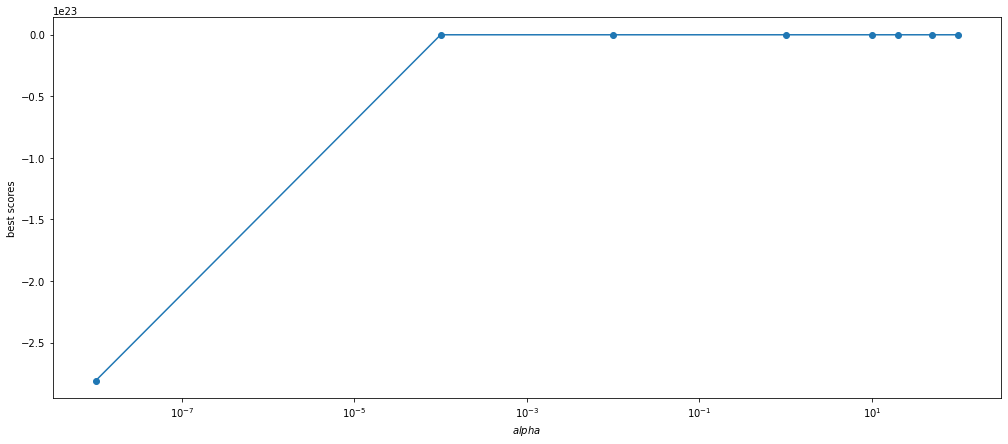

In [49]:
# Phương thức kFold
#splitter = KFold(5, random_state=42, shuffle=True)

# Các giá trị alpha đại diên cần kiểm tra
alps = [1e-8, 1e-4, 1e-2, 1.0, 10.0, 20.0, 50.0, 100.0]
scores =  np.array([])
for alp in alps:
    tmpRidge = RidgeCV(alphas=(alp, alp))
    tmpRidge.fit(X_train, y_train)
    scores= np.append(scores, [tmpRidge.best_score_])

scores = scores.transpose()

fig, ax = plt.subplots(1, 1, figsize=(17,7))
ax.plot(alps, scores, ls='-', marker='o')
ax.set_xscale('log')
ax.set_xlabel('$alpha$')
ax.set_ylabel('best scores');

In [50]:

ridgeCV_object = RidgeCV(alphas=(1e-8, 1e-4, 1e-2, 1.0, 10.0, 20.0, 50.0, 100.0))
ridgeCV_object.fit(X_train, y_train)

print("Best model searched:\nbest score = {}\nalpha = {}\nintercept = {}, ".format(ridgeCV_object.best_score_,
                                                                                                ridgeCV_object.alpha_,
                                                                                                 ridgeCV_object.intercept_,
                                                                                                 ))      
best_alpha = ridgeCV_object.alpha_

Best model searched:
best score = -7.191723834595236e+17
alpha = 1.0
intercept = [3.18210967e+09], 


In [51]:
est = Ridge(alpha=best_alpha).fit(X_train,y_train)
ypredict_ridge_best = est.predict(X_test)
scores =est.score(X_test,y_test)
scores 

0.552171327857593

### Lasoo


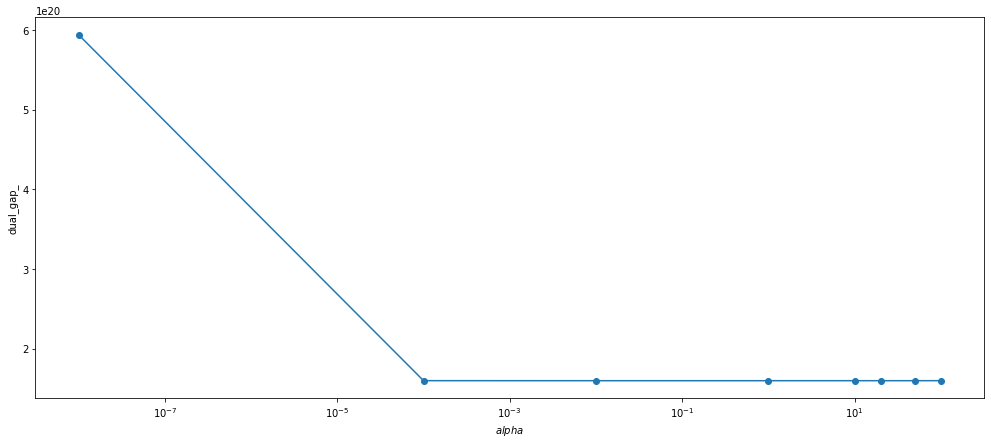

In [52]:
#splitter = KFold(5, random_state=42, shuffle=True)

alps = [1e-8, 1e-4, 1e-2, 1.0, 10.0, 20.0, 50.0, 100.0]
scores =  np.array([])
for alp in alps:
    tmpLasso = LassoCV(alphas=(alp, alp))
    tmpLasso.fit(X_train, y_train)
    scores= np.append(scores, [tmpLasso.dual_gap_])

scores = scores.transpose()

fig, ax = plt.subplots(1, 1, figsize=(17,7))
ax.plot(alps, scores, ls='-', marker='o')
ax.set_xscale('log')
ax.set_xlabel('$alpha$')
ax.set_ylabel('dual_gap_');

In [54]:
lassoCV_object = LassoCV(alphas=(1e-8, 1e-4, 1e-2, 1.0, 10.0, 20.0, 50.0, 100.0))
lassoCV_object.fit(X_train, y_train)

print("Best model searched:\ndual_gap_ = {}\nalpha = {}\nintercept = {}, ".format(lassoCV_object.dual_gap_,
                                                                                                lassoCV_object.alpha_,
                                                                                                 lassoCV_object.intercept_
                                                                                                 ))      


Best model searched:
dual_gap_ = 1.5990978851226386e+20
alpha = 1.0
intercept = 2552119989.3458595, 


In [55]:
est = Lasso(alpha=lassoCV_object.alpha_).fit(X_train,y_train)
ypredict_lasso_best = est.predict(X_test)
scores =est.score(X_test,y_test)
scores

0.5292301679428724